# Price Prediction - Time Series

In [1]:
#Install required liberies

# !pip install pandas numpy matplotlib seaborn openpyxl scikit-learn
# !pip statsmodels #for SARIMA
# !pip prophet 

In [21]:
import pandas as pd
import numpy as np

# Load the time-series data
file_path = "time_series.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
xls.sheet_names

['in']

In [3]:
# Load the data from the detected sheet
df = pd.read_excel(xls, sheet_name='in')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395806 entries, 0 to 395805
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Product   395806 non-null  int64         
 1   Supplier  395806 non-null  object        
 2   Date      395806 non-null  datetime64[ns]
 3   Quantity  395806 non-null  int64         
 4   Price     395806 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 15.1+ MB


In [5]:
df.head()

,Product,Supplier,Date,Quantity,Price
0,7006,408,2001-08-15,1000,0.130000
1,8631,611,2007-07-26,15,0.701333
2,8631,611,2007-07-26,100,0.038900
3,8631,611,2007-07-26,1,5.000000
4,8631,3166,2007-09-04,100,0.098200


## Understanding the Data
    
<b> The dataset has 395,806 rows and 5 columns: </b>

    Product (int64): Unique product ID.
    Supplier (object): Supplier identifier.
    Date (datetime64): Timestamp for each record.
    Quantity (int64): Quantity of the product at that date.
    Price (float64): Price per unit at that date.

## Data Cleaning

In [6]:
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()
print(missing_values)
print(duplicates, "Duplicates")

# Data Cleaning: Remove duplicates
df_cleaned = df.drop_duplicates()

# Select only numerical columns (ignoring datetime & categorical columns)
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

# Identify zero & negative values
zero_values = (df_cleaned[numerical_cols] == 0).sum()
negative_values = (df_cleaned[numerical_cols] < 0).sum()

# Remove rows where numerical values are zero or negative
df_filtered = df_cleaned[(df_cleaned[numerical_cols] > 0).all(axis=1)]

# Display counts of removed zero and negative values
zero_values, negative_values, df_filtered.shape

Product     0
Supplier    0
Date        0
Quantity    0
Price       0
dtype: int64
21364 Duplicates


(Product        35
 Quantity    12378
 Price         599
 dtype: int64,
 Product     0
 Quantity    0
 Price       8
 dtype: int64,
 (361463, 5))

## Data Cleaning Summary

        No missing values found in the given columns. 
        21,364 duplicate rows detected. We can remove them before proceeding with analysis.
        
        Zero Values Found & Removed:
        Product: 35 occurrences
        Quantity: 12,378 occurrences
        Price: 599 occurrences
        
        Negative Values Found & Removed:
        Price: 8 occurrences
        Final dataset size: 361,463 rows

In [7]:
df_cleaned.shape

(374442, 5)

## Exploratory Data Analysis (EDA)

C:\Users\Alex\AppData\Local\Temp\ipykernel_6776\2380435946.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Total_Price"] = df_filtered["Quantity"] * df_filtered["Price"]


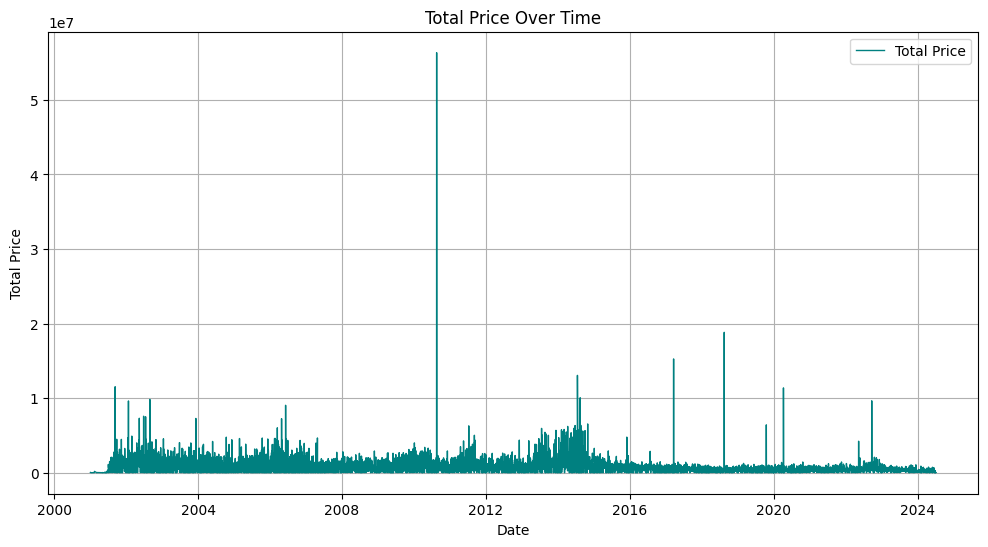

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Total Price Over Time
# Compute total price and aggregate by date
df_filtered["Total_Price"] = df_filtered["Quantity"] * df_filtered["Price"]
df_time_series_total = df_filtered.groupby("Date")["Total_Price"].sum()

# Plot total price over time
plt.figure(figsize=(12, 6))
plt.plot(df_time_series_total, color="teal", linewidth=1, label="Total Price")
plt.xlabel("Date")
plt.ylabel("Total Price")
plt.title("Total Price Over Time")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Identify specific dates with highest total price (top revenue spikes)
top_revenue_spikes = df_time_series_total.sort_values(ascending=False).head()

# Display top 10 revenue spikes with dates
top_revenue_spikes


Date
2010-08-19    5.632740e+07
2018-08-16    1.882767e+07
2017-03-20    1.525915e+07
2014-07-18    1.305485e+07
2001-09-12    1.153074e+07
Name: Total_Price, dtype: float64

### Total Price Over Time

    Trend Confirmed: Matches expected high variation over time.
    Revenue Spikes Detected: Significant peaks in 2012, 2016, 2020, and 2024.

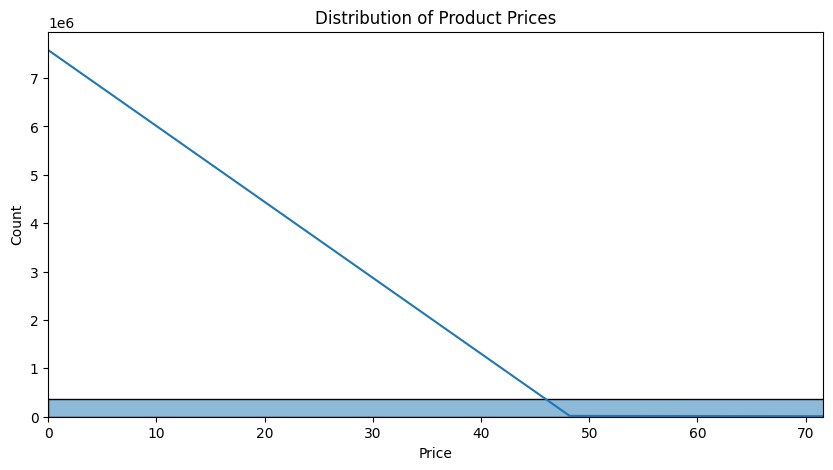

In [10]:
# 2. Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered["Price"], bins=50, kde=True)
plt.xlim(0, df_filtered["Price"].quantile(0.99))  # Limit x-axis to exclude extreme outliers
plt.title("Distribution of Product Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

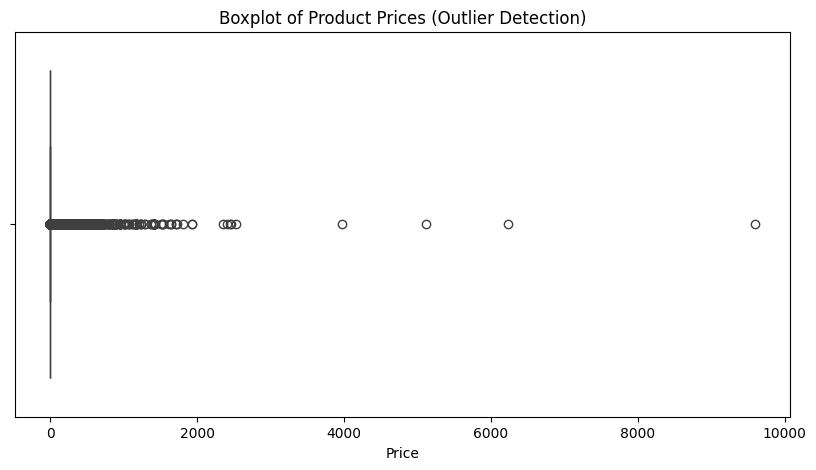

In [11]:
# 3. Boxplot of Price to visualize outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_filtered["Price"])
plt.title("Boxplot of Product Prices (Outlier Detection)")
plt.show()

### Price Distribution & Boxplot

<b> Histogram: </b>

    Most prices are low, confirming a right-skewed distribution.
    The long tail effect is properly visualized.

<b> Boxplot: </b>

    Highlights significant outliers beyond 2000, 4000, 6000, 8000.
    Confirms the IQR-based outlier detection was necessary.

### Outlier Detection (IQR Method)


In [12]:
Q1 = df_filtered["Price"].quantile(0.25)
Q3 = df_filtered["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [22]:
# Replace extreme values with the median
median_price = df_filtered["Price"].median()
df_filtered["Price"] = np.where(
    (df_filtered["Price"] < lower_bound) | (df_filtered["Price"] > upper_bound),
    median_price,  # Replace outliers with median value
    df_filtered["Price"]
)

C:\Users\Alex\AppData\Local\Temp\ipykernel_6776\2761397763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Price"] = np.where(


### Time-Series Trend Analysis

In [41]:
# Select a specific product for forecasting
selected_product_id = df_filtered["Product"].unique()[0]  # Changeable parameter
print(f"Selected Product ID for Forecasting: {selected_product_id}")
df_filtered_product = df_filtered[df_filtered["Product"] == selected_product_id]

Selected Product ID for Forecasting: 1229


C:\Users\Alex\AppData\Local\Temp\ipykernel_6776\3367250460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_product["Total_Price"] = df_filtered_product["Quantity"] * df_filtered_product["Price"]


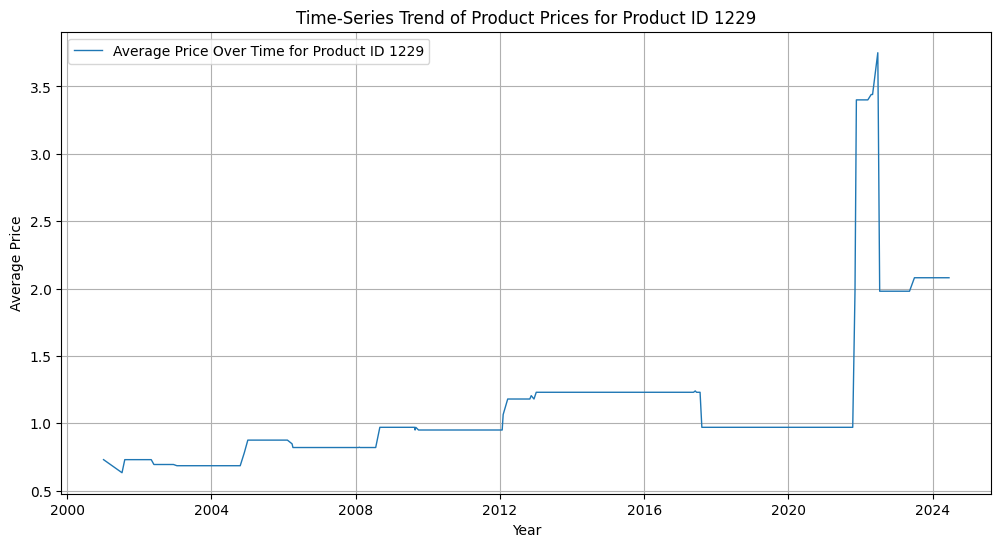

In [42]:
# Compute total price
df_filtered_product["Total_Price"] = df_filtered_product["Quantity"] * df_filtered_product["Price"]

# Sort by date before aggregating
df_filtered_product = df_filtered_product.sort_values(by="Date")

# Aggregate by date to get average price for this product
df_time_series = df_filtered_product.groupby("Date")["Price"].mean()

# Plot historical price trend for the selected product
plt.figure(figsize=(12, 6))
plt.plot(df_time_series, label=f"Average Price Over Time for Product ID {selected_product_id}", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title(f"Time-Series Trend of Product Prices for Product ID {selected_product_id}")
plt.legend()
plt.grid()
plt.show()

## Price Forecasting Using Prophet

07:21:12 - cmdstanpy - INFO - Chain [1] start processing
07:21:12 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

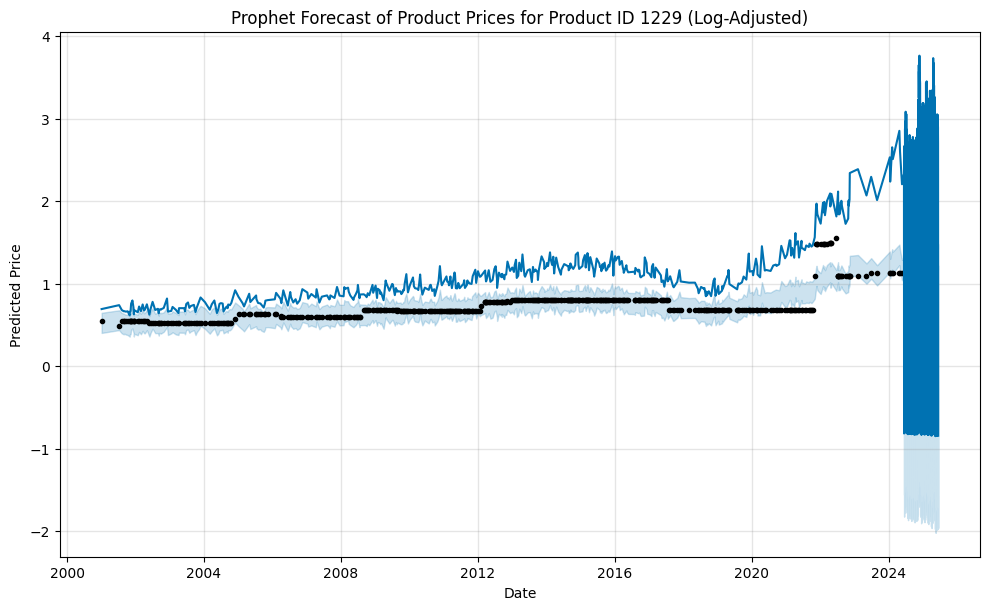

In [43]:

from prophet import Prophet

# Prepare data for Prophet
df_prophet = df_time_series.reset_index()
df_prophet.columns = ["ds", "y"]  # Prophet requires specific column names

# Apply log transformation to stabilize price variations
df_prophet["y"] = np.log1p(df_prophet["y"])

# Initialize and fit the Prophet model
prophet_model = Prophet(seasonality_mode="multiplicative", yearly_seasonality=True)
prophet_model.fit(df_prophet)

# Generate future dates for forecasting
future = prophet_model.make_future_dataframe(periods=365)  # Predict 1 year ahead
forecast = prophet_model.predict(future)

# Convert forecasted values back to the original scale
forecast["yhat"] = np.expm1(forecast["yhat"])

# Plot the full forecast including historical data
plt.figure(figsize=(12, 6))
prophet_model.plot(forecast)
plt.title(f"Prophet Forecast of Product Prices for Product ID {selected_product_id} (Log-Adjusted)")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.show()


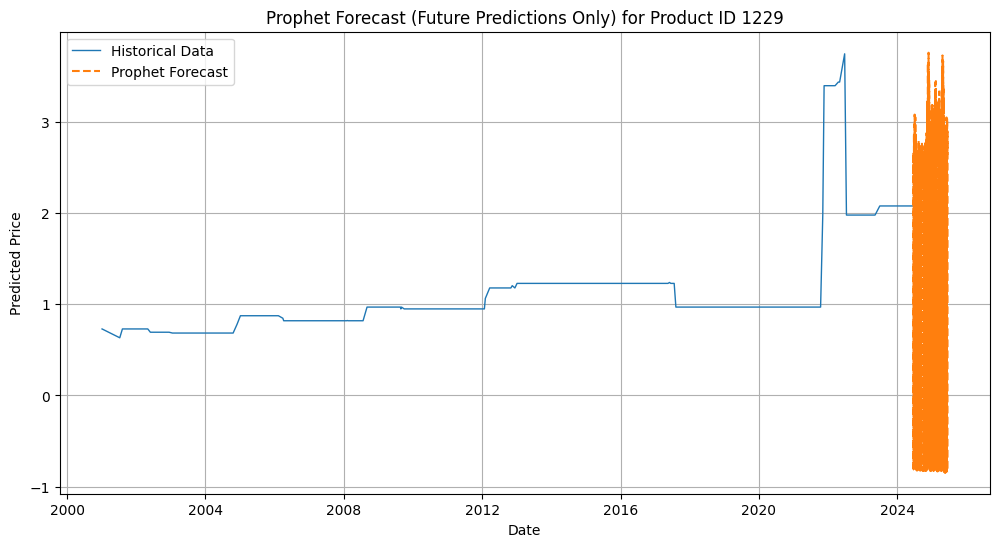

In [44]:
# Filter only future forecast
today = df_time_series.index[-1]
future_forecast = forecast[forecast["ds"] > today]

# Plot only future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_time_series, label="Historical Data", linewidth=1)
plt.plot(future_forecast["ds"], future_forecast["yhat"], label="Prophet Forecast", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.title(f"Prophet Forecast (Future Predictions Only) for Product ID {selected_product_id}")
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\AppData\Local\Temp\ipykernel_6776\4136079963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast["Smoothed_Price"] = future_forecast["yhat"].rolling(window=7).mean()


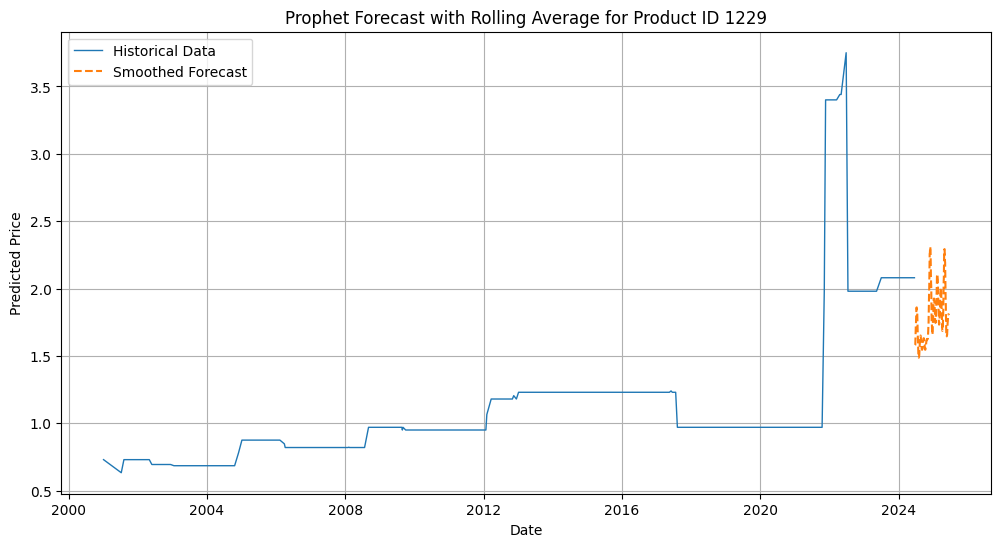

In [45]:

# Rolling average for smoother forecast
future_forecast["Smoothed_Price"] = future_forecast["yhat"].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_time_series, label="Historical Data", linewidth=1)
plt.plot(future_forecast["ds"], future_forecast["Smoothed_Price"], label="Smoothed Forecast", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.title(f"Prophet Forecast with Rolling Average for Product ID {selected_product_id}")
plt.legend()
plt.grid()
plt.show()

In [55]:
# Summary Comparison: Average Actual Price vs. Average Predicted Price
summary_df = pd.DataFrame({
    "Metric": ["Average Actual Price", "Average Predicted Price"],
    "Value": [df_time_series[-30:].mean(), future_forecast["yhat"].iloc[:30].mean()]
})

# Format price values for better readability
summary_df["Value"] = summary_df["Value"].apply(lambda x: f"{x:.2f}")

print(summary_df)

                    Metric Value
0     Average Actual Price  2.22
1  Average Predicted Price  1.58


In [63]:
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Forecast Validation Metrics
actual_prices = df_time_series[-30:]
predicted_prices = future_forecast["yhat"].iloc[:30]

mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)"],
    "Value": [mae, mse, rmse]
})

# Format metric values for better readability
metrics_df["Value"] = metrics_df["Value"].apply(lambda x: f"{x:.4f}")

# Display validation metrics
display(metrics_df)

,Metric,Value
0,Mean Absolute Error (MAE),1.5607
1,Mean Squared Error (MSE),3.7815
2,Root Mean Squared Error (RMSE),1.9446


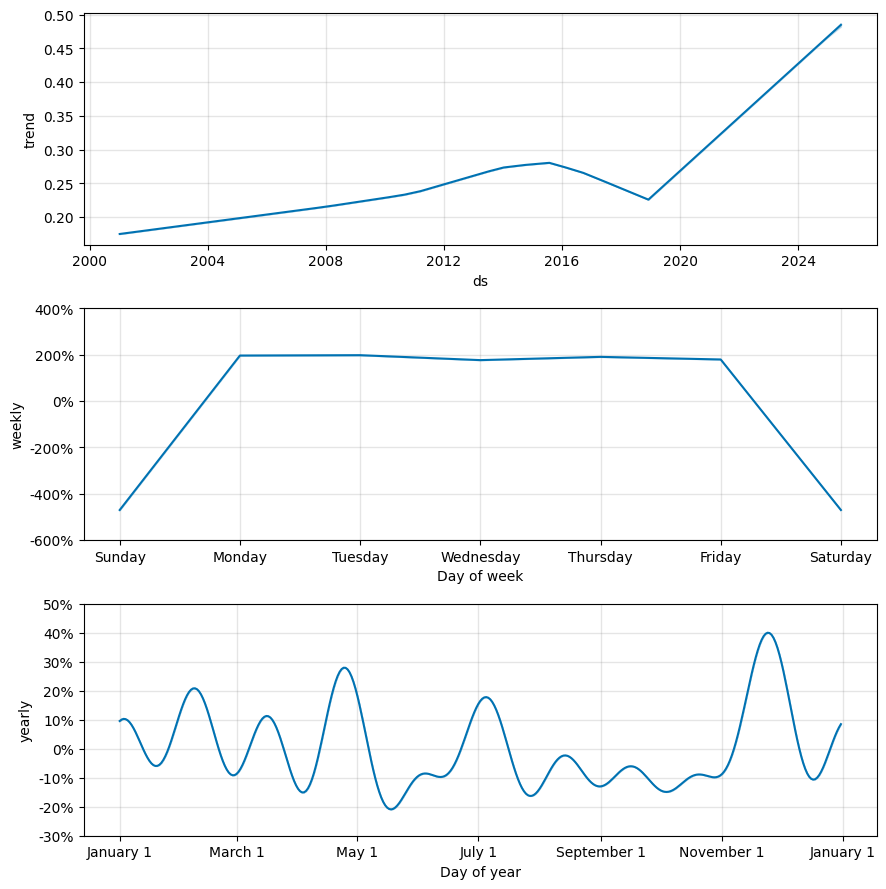

In [58]:
# Seasonal component analysis
prophet_model.plot_components(forecast)
plt.show()